In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from random import normalvariate
from math import sqrt
import sys

In [2]:
print('Python:', sys.version.split(" ")[0])
print('Numpy:', np.__version__)
print('Matplotlib:', matplotlib.__version__)

Python: 3.10.6
Numpy: 1.24.0
Matplotlib: 3.1.1


## Watermark and Host Images <br>
Watermark and host image were taken and adjusted to the desired format.

In [3]:
def resizer(image, new_size):
    """
    Even if an RGB image is inserted, it outputs it as grayscale.
    Because I did not consider the RGB values.
    """ 
    image = np.real(image)

    x_resz, y_resz = new_size[0], new_size[1]
    x_real, y_real = image.shape[0], image.shape[1]

    x_scalefactor = x_real / x_resz
    y_scalefactor = y_real / y_resz
    
    resized_image = np.zeros((x_resz, y_resz), dtype=np.float64)
    for i in range(x_resz):
        for j in range(y_resz):
            block = image[int(i*x_scalefactor) : int((i+1)*x_scalefactor) , int(j*y_scalefactor) : int((j+1)*y_scalefactor)]

            total = np.sum(block)
            size = np.size(block)
            value = total / size
            resized_image[i][j] = np.float64(value) 
               
    return resized_image

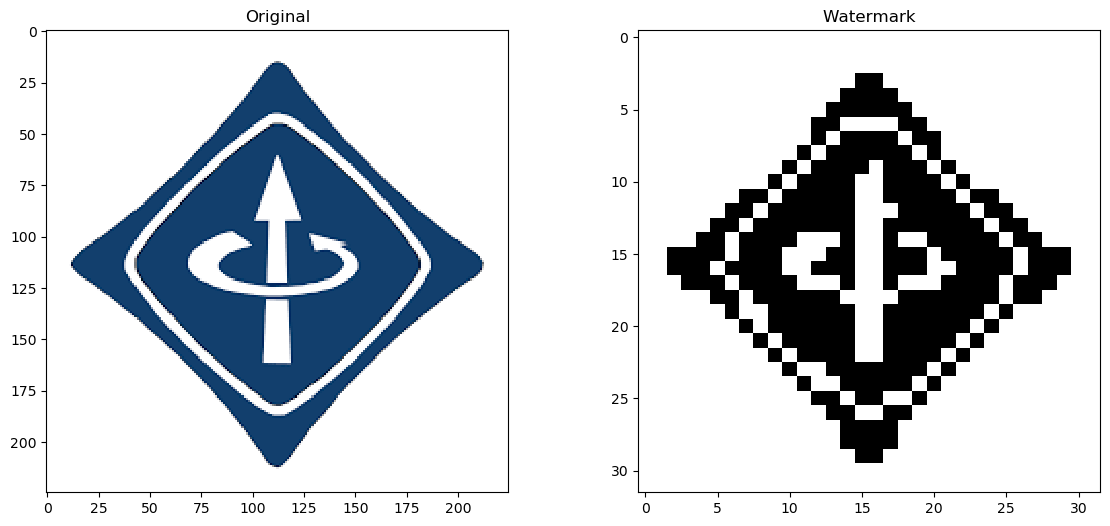

(32, 32)


In [4]:
org_image = plt.imread("images/watermark.png")

wa_size = 32
org_watermark_image = resizer(org_image, (wa_size, wa_size))

watermark_image = np.zeros_like(org_watermark_image)
for i in range(len(org_watermark_image)):
    for j in range(len(org_watermark_image[0])):
        if org_watermark_image[i][j] <= 0.5:
            watermark_image[i][j] = 0
        else:
            watermark_image[i][j] = 1

watermark = watermark_image

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(org_image, cmap="gray")
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(watermark, cmap="gray")
plt.title("Watermark")
plt.show()

print(watermark.shape)

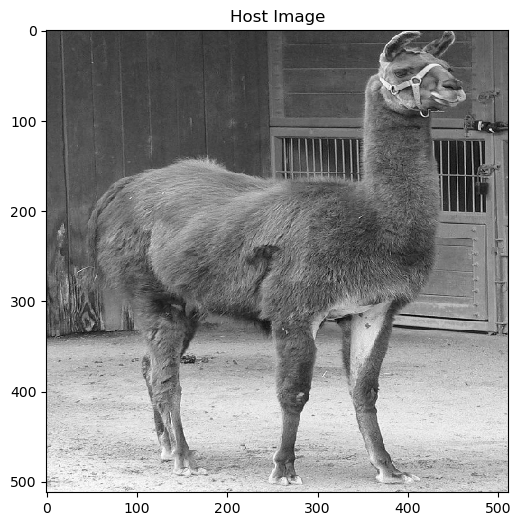

(512, 512)


In [5]:
image = plt.imread("images/host.jpg")
im_size = 1
while(im_size < min(image.shape[0],image.shape[1])/2):
    im_size *= 2

host_image = resizer(image, (im_size, im_size))

plt.figure(figsize=(7,6))
plt.imshow(host_image, cmap="gray")
plt.title("Host Image")
plt.show()

host = np.abs(np.real(host_image))

print(host.shape)


## SVD (Singular Value Decomposition)

Power mothod used to found U, s and V. To do power method iteratively all the values obtained.

In [6]:
def norm(v):
    # Size of vector
    total = 0
    for num in v:
        total += num*num
    return sqrt(total) 

In [7]:
np.seterr(divide='ignore', invalid='ignore')

def power_method(A, epsilon=1e-10, max_iterations=50):
    ATA = np.dot(A.T, A)
    
    lastV = None
    currentV = []
    gaussian_distribution = []
    for _ in range(A.shape[0]):
        gaussian_distribution.append(normalvariate(0, 1))
    the_norm = norm(gaussian_distribution)
    for num in gaussian_distribution:
        currentV.append(num/the_norm)
      
    iterations = 0
    while iterations < max_iterations:
        iterations += 1
        lastV = currentV
        currentV = np.dot(ATA, lastV)
        currentNorm = norm(currentV)
        
        currentV = currentV / currentNorm

        if abs(np.dot(currentV, lastV)) > 1 - epsilon:
            return currentV
        
    return currentV


def SVD(A, epsilon=1e-10):
    # Assumption: A matrix is square
    A = np.array(A, dtype=float)
    
    svd = []
    
    for i in range(A.shape[0]):
        one_value = A.copy()
        """
        The dominating direction should be eliminated from the matrix, 
        and the most dominant singular value should be found again. 
        In order to accomplish that, we might use singular values 
        and previously computed left and right singular vectors 
        to subtract the prior eigenvector(s) component(s) from the original matrix.
        """
        for u, s, v in svd[:i]:
            one_value -= s * np.outer(u, v)
        
        v = power_method(one_value, epsilon=epsilon)  
        u_unnormalized = np.dot(A, v)
        sigma = norm(u_unnormalized) 
        u = u_unnormalized / sigma

        svd.append((u, sigma, v))
        
    us, singularValues, vs = [np.array(x) for x in zip(*svd)]
    s = np.diag(singularValues)
    return us.T, s, vs

Considering the big <i>host image</i>, the part of the reconstruction may take too many times. To get the results faster, this block may be added to the comments.

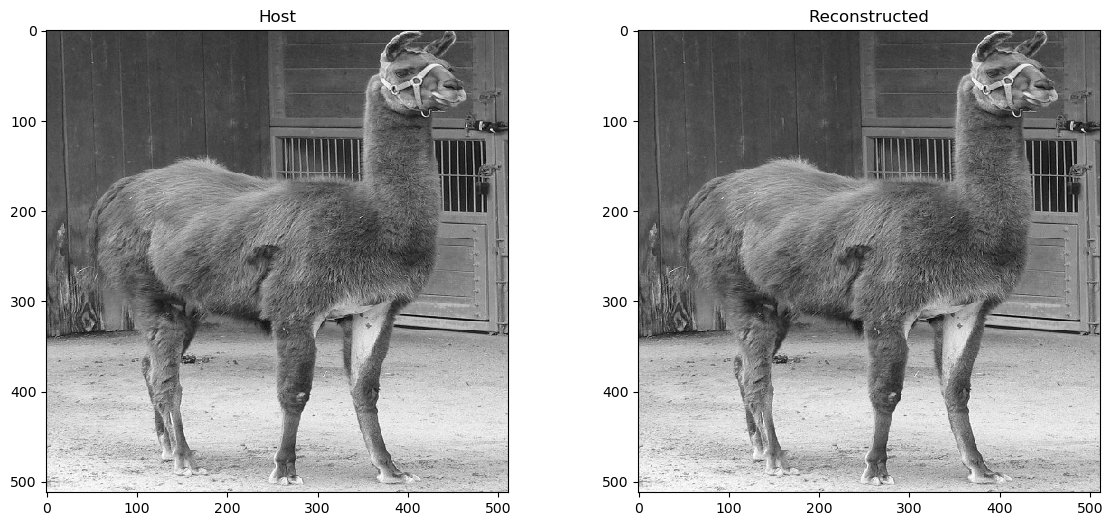

In [8]:
U, s, VT = SVD(host_image)

reconstructed_image = np.dot(U, np.dot(s, VT))

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.title("Host")
plt.imshow(host_image, cmap="gray")
plt.subplot(1,2,2)
plt.title("Reconstructed")
plt.imshow(reconstructed_image, cmap="gray")
plt.show()

## Embedding Watermark

In [9]:
Q = 34

In [10]:
def embed_watermark(host_image, watermark):
    """
    Watermark embedding procedure which mentioned in the paper.
    """
    R1 = host_image.shape[0] // watermark.shape[0]
    R2 = host_image.shape[1] // watermark.shape[1]

    watermarked_image = np.empty_like(host_image)

    for i in range(0, watermark.shape[0]):
        for j in range(0, watermark.shape[1]):
            watermark_bit = watermark[i][j]
            # Step 1 , block partition
            # Step 2 , SVD 
            U, s, VT = SVD(host_image[i*R1:(i+1)*R1 , j*R2:(j+1)*R2])
            
            # Step 3 , quantize largest coefficient
            Z = s[0][0] % Q
            
            # Step 4-5 , algorithm
            if watermark_bit <= 0.5:
                if Z < 3*Q/4:
                    s[0][0] = s[0][0] + Q/4 - Z
                else:
                    s[0][0] = s[0][0] + 5*Q/4 - Z
            else:
                if Z < Q/4:
                    s[0][0] = s[0][0] - Q/4 + Z
                else:
                    s[0][0] = s[0][0] + 3*Q/4 - Z
            
            # Step 6 , reconstruct
            watermarked_image[i*R1:(i+1)*R1 , j*R2:(j+1)*R2] = np.dot(U, np.dot(s, VT))
    return watermarked_image

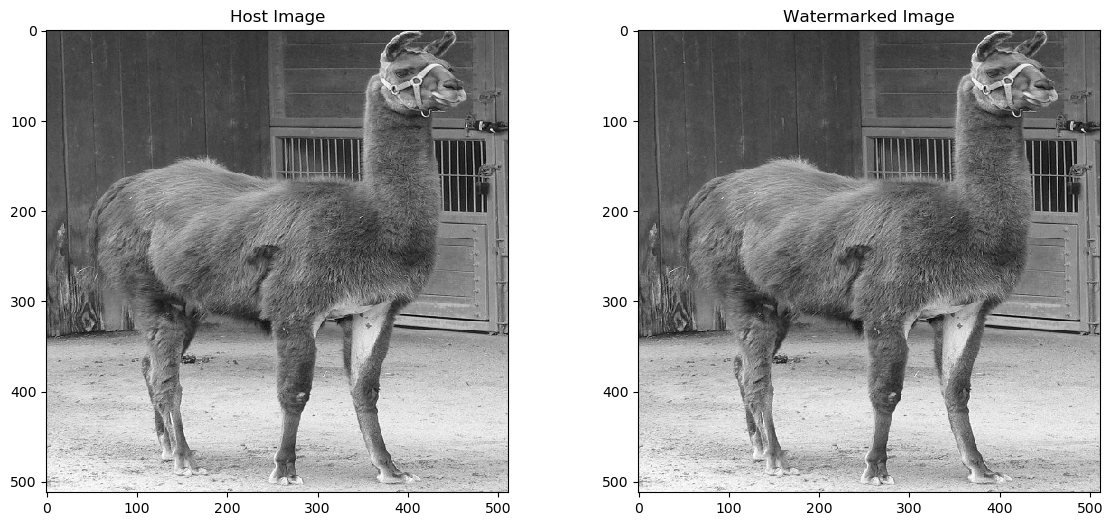

In [11]:
watermarked_image = embed_watermark(host, watermark)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.title("Host Image")
plt.imshow(host_image, cmap="gray")
plt.subplot(1,2,2)
plt.title("Watermarked Image")
plt.imshow(watermarked_image, cmap="gray")
plt.show()

## Extracting Watermark

In [12]:
ratio = host_image.shape[0] // watermark.shape[0] 

In [13]:
def extract_watermark(watermarked_image):
    """
    Watermark extracting procedure which mentioned in the paper.
    """
    watermark = list()
    for i in range(0, watermarked_image.shape[0] // ratio):
        row = list()
        for j in range(0, watermarked_image.shape[1] // ratio):
            # 1. step , block partition
            # 2. step , SVD
            U, s, VT = SVD(watermarked_image[i*ratio:(i+1)*ratio , j*ratio:(j+1)*ratio])
            
            # Step 3 , quantize largest coefficient
            Z = s[0][0] % Q
            
            # Step 4 , algorithm
            if(Z < Q/2):
                row.append(0)
            else:
                row.append(1)
        watermark.append(row)
            
    size = len(watermark)
    watermark = np.array(watermark).reshape((size, size))
    
    return watermark

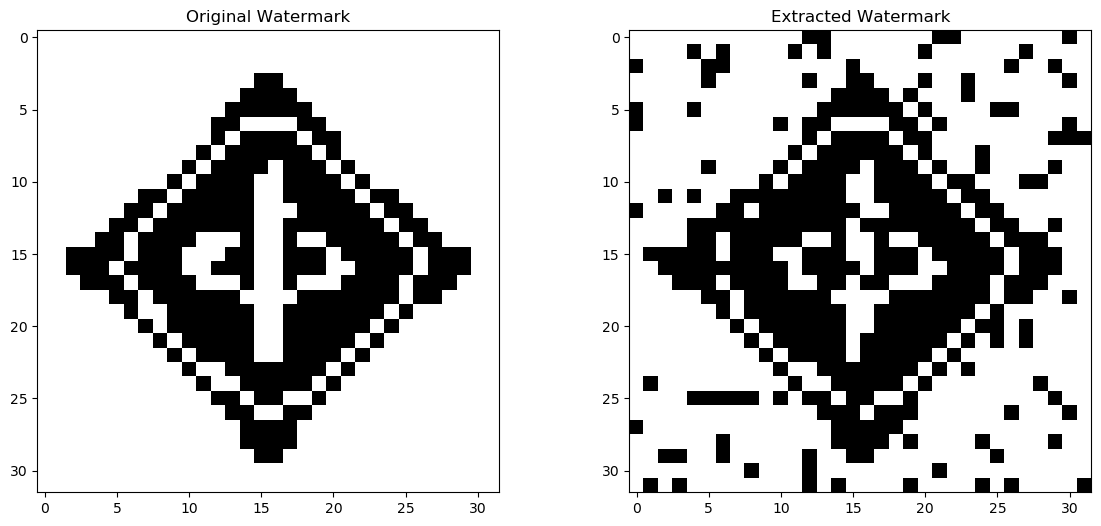

In [14]:
extracted_watermark = extract_watermark(watermarked_image)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.title("Original Watermark")
plt.imshow(watermark, cmap="gray")
plt.subplot(1,2,2)
plt.title("Extracted Watermark")
plt.imshow(extracted_watermark, cmap="gray")
plt.show()

## PSNR Value

In [15]:
# peak signal-to-noise ratio
def psnr(host_image, watermarked_image):
    mse = np.mean((host_image - watermarked_image) ** 2)
    
    max_pixel = 255.0
    
    psnr_val = 10 * np.log10((max_pixel ** 2) / mse)
    return int(psnr_val)

psnr_W = psnr(host_image, watermarked_image)
print(psnr_W, "dB")

53 dB


## Extrancting Watermark from Tampered Image

In [16]:
tampered_image = np.copy(watermarked_image)

# Scale factor for all size of images
scale_factor = im_size / 128

# Tampering the watermarked image
tampered_image[int(50 * scale_factor):int(78 * scale_factor), int(5 * scale_factor):int(10 * scale_factor)] = 0 
tampered_image[int(50 * scale_factor):int(53 * scale_factor), int(10 * scale_factor):int(15 * scale_factor)] = 0 
tampered_image[int(53 * scale_factor):int(78 * scale_factor), int(15 * scale_factor):int(20 * scale_factor)] = 0  
tampered_image[int(50 * scale_factor):int(78 * scale_factor), int(20 * scale_factor):int(25 * scale_factor)] = 0  
tampered_image[int(50 * scale_factor):int(78 * scale_factor), int(25 * scale_factor):int(30 * scale_factor)] = 0 

tampered_image[int(50 * scale_factor):int(60 * scale_factor), int(55 * scale_factor):int(75 * scale_factor)] = 123  
tampered_image[int(70 * scale_factor):int(80 * scale_factor), int(55 * scale_factor):int(75 * scale_factor)] = 43  
tampered_image[int(50 * scale_factor):int(108 * scale_factor), int(55 * scale_factor):int(65 * scale_factor)] = 219 
tampered_image[int(50 * scale_factor):int(60 * scale_factor), int(65 * scale_factor):int(75 * scale_factor)] = 14  

tampered_image[int(50 * scale_factor):int(78 * scale_factor), int(90 * scale_factor):int(95 * scale_factor)] = 255  
tampered_image[int(50 * scale_factor):int(53 * scale_factor), int(95 * scale_factor):int(100 * scale_factor)] = 255 
tampered_image[int(53 * scale_factor):int(78 * scale_factor), int(100 * scale_factor):int(105 * scale_factor)] = 255  
tampered_image[int(50 * scale_factor):int(53 * scale_factor), int(105 * scale_factor):int(110 * scale_factor)] = 90 
tampered_image[int(50 * scale_factor):int(78 * scale_factor), int(110 * scale_factor):int(115 * scale_factor)] = 90  

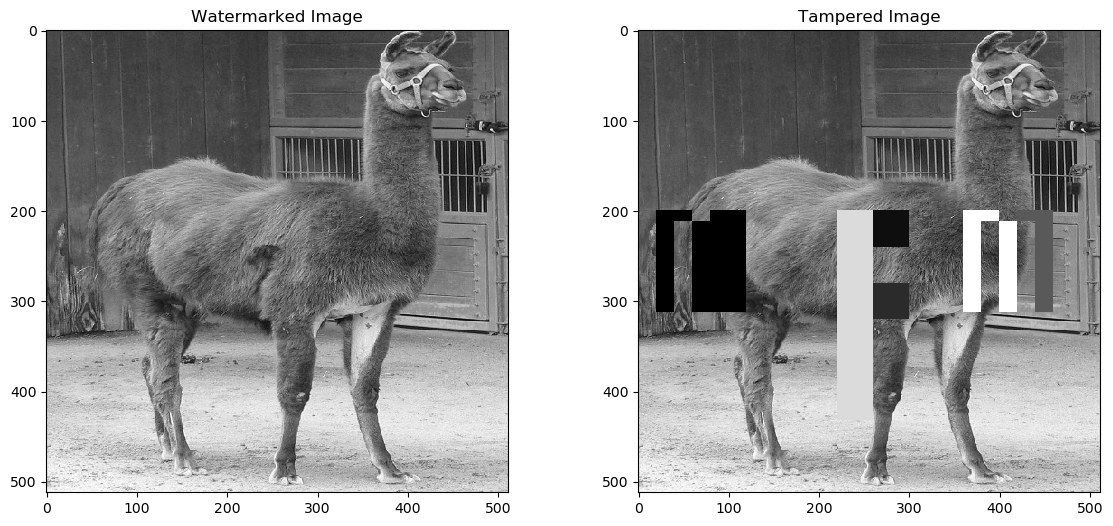

In [17]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.title("Watermarked Image")
plt.imshow(watermarked_image, cmap="gray")
plt.subplot(1,2,2)
plt.title("Tampered Image")
plt.imshow(tampered_image, cmap="gray")
plt.show()

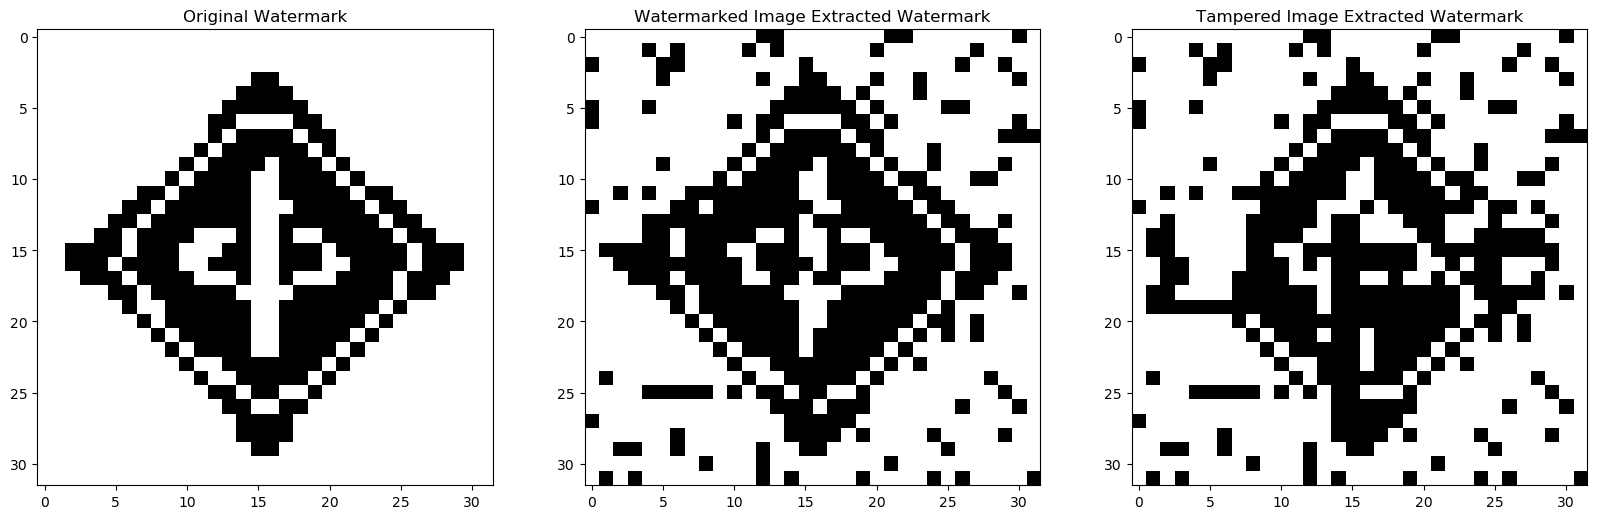

In [18]:
extracted_watermark_fromTampered = extract_watermark(tampered_image)

plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.title("Original Watermark")
plt.imshow(watermark, cmap="gray")
plt.subplot(1,3,2)
plt.title("Watermarked Image Extracted Watermark")
plt.imshow(extracted_watermark, cmap="gray")
plt.subplot(1,3,3)
plt.title("Tampered Image Extracted Watermark")
plt.imshow(extracted_watermark_fromTampered, cmap="gray")

plt.show()

In [ ]:
#  Saving the wanted outputs to output file
plt.imshow(host_image, cmap="gray")
plt.axis("off")
plt.savefig("output/output_host_image.png", cmap="gray", bbox_inches='tight', pad_inches=0)
plt.show()
plt.imshow(watermarked_image, cmap="gray")
plt.axis("off")
plt.savefig("output/output_watermarked_image.png", cmap="gray", bbox_inches='tight', pad_inches=0)
plt.show()
plt.imshow(tampered_image, cmap="gray")
plt.axis("off")
plt.savefig("output/output_tampered_image.png", cmap="gray", bbox_inches='tight', pad_inches=0)
plt.show()
plt.imshow(watermark, cmap="gray")
plt.axis("off")
plt.savefig("output/output_watermark.png", cmap="gray", bbox_inches='tight', pad_inches=0)
plt.show()
plt.imshow(extracted_watermark, cmap="gray")
plt.axis("off")
plt.savefig("output/output_watermark_extracted.png", cmap="gray", bbox_inches='tight', pad_inches=0)
plt.show()
plt.imshow(extracted_watermark_fromTampered, cmap="gray")
plt.axis("off")
plt.savefig("output/output_watermark_extracted_fromTampered.png", cmap="gray", bbox_inches='tight', pad_inches=0)
plt.show()